<h1 align="center">Autoencoder exercises</h1> 
 

## Loading packages

In [12]:
import matplotlib.pyplot as plt
# use interactive backend
%matplotlib notebook
import numpy as np

import tensorflow as tf

#!pip install --upgrade tensorflow-probability
import tensorflow_probability as tfp

# Forcing Tenosrflow to use CPU
tf.config.experimental.set_visible_devices([], 'GPU')

### A function to display images

In [13]:
def dis_img(x,y, labeldict, title = None):
    
    indx = np.random.choice(range(x.shape[0]) , 16 )   
    fig, ax = plt.subplots(4, 4,
                           figsize=(6,5),
                           subplot_kw={'xticks': [], 'yticks': []},
                           num= title ) 
    fig.subplots_adjust(hspace=.4, wspace=0)
    imag = [ (x[ind],y[ind])  for ind in indx] 
    for coef, ax in zip(imag, ax.ravel()):
        ax.imshow(coef[0].reshape(28, 28), cmap=plt.cm.gray)     
        ax.set_title(labeldict[coef[1]])

## Loading and pre-processing the data

Original Fashion-MNIST data has $70000$ samples. To make the training process faster, here we have a smaller size of this dataset.

Train-data shape:  (15000, 28, 28)
Test-data shape:  (2000, 28, 28)


<IPython.core.display.Javascript object>


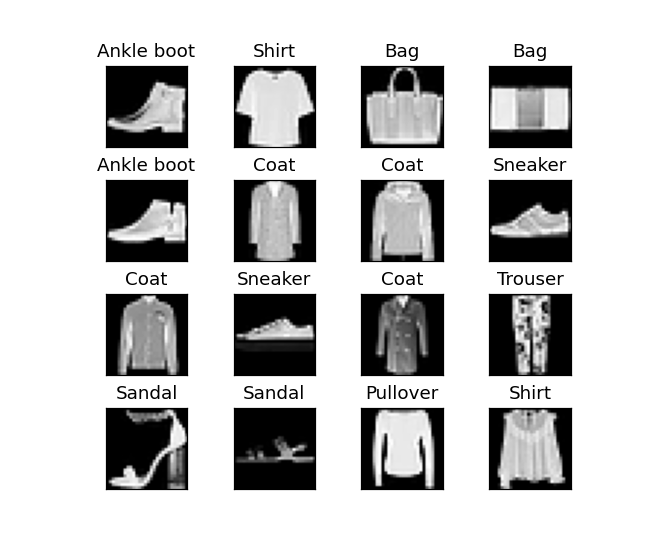

In [14]:
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


train = np.load('fashion_train.npz')
test = np.load('fashion_test.npz')
x_train, y_train = train['x'], train['y']
x_test, y_test = test['x'], test['y']



print('Train-data shape: ', x_train.shape)
print('Test-data shape: ', x_test.shape)


labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


x_train = x_train.reshape(-1, 784).astype('float32') /255.
x_test = x_test.reshape(-1, 784).astype('float32') /255.


dis_img(x_train,y_train, labeldict,'random_samples')


<h1 align="center">Autoencoder </h1> 


#### Two ways of building the models:
Encoder $\rightarrow  z = g_w(x)$

Decoder $\rightarrow  \tilde{x} = f_w(z)$


   * Sequential API with Functional API:
   <br><br>
  `encoder = tf.keras.Sequential([ layer_1, ..] )
    decoder = tf.keras.Sequential([ layer_1, ..] )
    Autoenocder = tf.keras.Model(inputs = enocder.inputs, outputs = decoder(encoder.outputs)`
 
   
 
   
   * Model subclassing:
   <br><br>
   `class Autoencoder(tf.keras.Model):
       def __ini__t(self):
        super(Autoneocder, self).__init__()
        encoder = self.encoder()
        decoder = delf.decoder() 
       def enocder()
       def decoder()
       `

#### Steps:     
1. Build encoder, decoder, and the autoencoder as models. 
2. Decide on the format of the layers. Use a correct activation function that suites the data.
3. To build a denoising autoencoder, one can add dropout layers to hidden layers in encoder and decoder.

In [15]:
inp_dim = 784
hidden_dim = 50
latent_dim = 3

In [16]:
# Encoder model
encoder = tf.keras.Sequential([
    tf.keras.Input(inp_dim ),
    #tf.keras.layers.Dropout(0.3), # In case we want denoising
    tf.keras.layers.Dense(units=hidden_dim , activation='relu'), # hidden layer
    tf.keras.layers.Dense(units=latent_dim, activation='relu'),  # latent layer (z)
])


# Decoder model
decoder = tf.keras.Sequential([
    tf.keras.Input(latent_dim),
    tf.keras.layers.Dense(units=hidden_dim , activation='relu'),# hidden layer
    tf.keras.layers.Dense(units=inp_dim , activation='sigmoid')# output layer
    ])



# Autoencoder model
AE= tf.keras.models.Model( inputs = encoder.inputs, outputs =decoder(encoder.outputs), name= 'AE')


#### Compiling and training the model
* Hyperparameters
* The error (cost) funstion

In [17]:
lr =  1e-4
batch_size = 32
epoch = 50


AE.compile(optimizer=tf.keras.optimizers.Adam( lr ),              
            loss =tf.keras.losses.binary_crossentropy)


history_ae = AE.fit(x_train,
                 x_train,
                 batch_size = batch_size,
                 epochs = epoch,
                 validation_split = 0.3,
                 shuffle= True,
                 verbose=0)

<IPython.core.display.Javascript object>


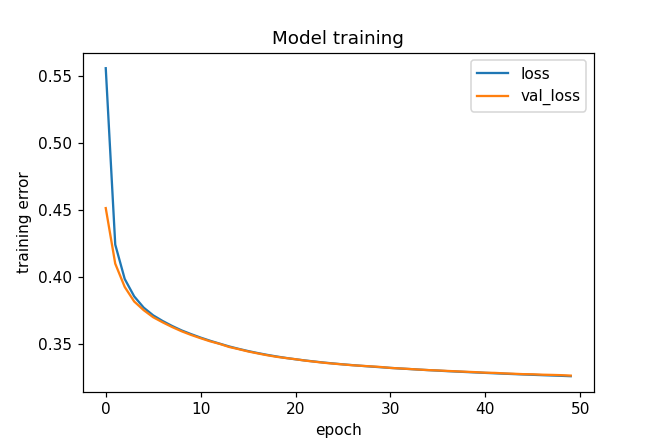

In [18]:
plt.figure('Training AE', figsize=(6,4))
for k in history_ae.history.keys():
    plt.plot(history_ae.history[k], label = k)
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
plt.legend(loc='upper right')

Test loss: 0.3280942738056183


<IPython.core.display.Javascript object>


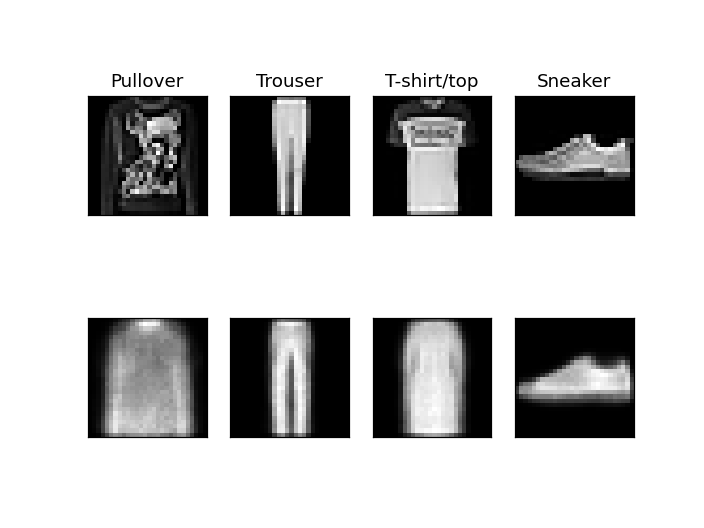

In [19]:
# Evaluate on test data
result = AE.evaluate(x_test, x_test, batch_size=batch_size, verbose= 0)
print("Test loss:", result)


x_hat = AE(x_test).numpy()

#index = np.random.choice(2000,  4)
index = [  89, 1042,  989, 1866]
fig, ax = plt.subplots(2, 4, num = 'Autoenocder reconstruction',
                       subplot_kw={'xticks': [], 'yticks': []})

for i, ind in enumerate(index):
    ax[0,i].imshow(x_test[ind].reshape(28,28), cmap='gray')
    ax[0,i].set_title(labeldict[y_test[ind]])
    ax[1,i].imshow(x_hat[ind].reshape(28,28), cmap='gray')
    

    

<h1 align="center">Variational autoencoder </h1> 
 
 <br><br>
 <br><br>
 
 ### Tensoflow probability and probabilistic layers  [TFP](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions)
 `!pip install --upgrade tensorflow-probability`
 
 * Latent distribution: We choose diagonal multivariate Gaussian (axis-aligned)<br><br>
    $$q_\phi(Z|X) =\prod_{i} \mathcal{N}(z_i| \mu_i(X), \sigma^2_i(X))$$  
     $$z \sim q(z|x)$$

 * Output layer: Bernoulli distribution<br><br>
 
 
   `encoder = tf.keras.Sequential()` <br><br>
   `encode.add(layer1), ...`<br><br>
   `mu = Dense(latent_dim, 'linear')`<br><br>
   `var = Dense(latent_dim, 'softplus')`<br><br>
   `encoder.add(mu, var)`<br><br>
   `q_z = tfp.distributions.MultivariateNormalDiag(loc = mu , scale_diag= var )`<br><br>   
   
   `decoder = tf.keras.Sequential()` <br><br>
   `decode.add(tf.keras.layers.Dense(self.inp_shape, name='logits'))`<br><br>
   `decode.add(tfp.layers.IndependentBernoulli(self.inp_shape, tfp.distributions.Bernoulli.logits)`<br><br>
   `Autoenocder = tf.kera.Model(inputs = z, outputs = decoder(encoder.outputs)`
   <br><br>
   
 
### VAE objective as log-likelihood of the distributions:
Minimizing the evidence lower bound = negative log likelihood of data + KL divergence
$$\text{ELBO} \approx -\log p(x|z) + \log q(z|x) -\log p(z) $$
 
Tensorflow probability provides log probability density function: `log_prob()` 

`p_z = tfp.distributions.MultivariateNormalDiag(latent_size)
LL = p_z.log_prob(z)`
 

In [20]:
class VAE(tf.keras.Model):
    #subclassing the Model class
    Default = {'encod_size':  None,
               'decod_size': None,
               'inp_shape':None,
               'act_fun': 'relu', 
               'batch_size': 200,
               'l2' : 0
               }
    
    def __init__(self, hyper_p):
        super(VAE, self).__init__()
        self.__dict__.update(self.Default, **hyper_p )
        
        #prior
        self.p_z = tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(self.encod_size[-1]))
        
        self.encoder = self.make_encoder()
        self.decoder = self.make_decoder()                  
    
    def posterior(self, args):
        z_mu , z_var = args
        return tfp.distributions.MultivariateNormalDiag(loc = z_mu , scale_diag= z_var ) 
            
    def make_encoder(self):
        inp = tf.keras.Input(self.inp_shape)
        x = inp
        
        for lay in self.encod_size[:-1]:
            x = tf.keras.layers.Dense(lay, 
                                       kernel_regularizer =tf.keras.regularizers.l2(self.l2),
                                      activation = self.act_fun)(x)
        z_mu = tf.keras.layers.Dense(self.encod_size[-1], activation = 'linear')(x)
        z_var = tf.keras.layers.Dense(self.encod_size[-1], activation = 'softplus')(x)
        
        return tf.keras.models.Model(inp, [z_mu, z_var], name= 'Encoder')
        
        
    def make_decoder(self):
        inp = tf.keras.Input(self.encod_size[-1])
        x = inp
        for lay in self.decod_size:
            
            x = tf.keras.layers.Dense(lay,
                                      kernel_regularizer =tf.keras.regularizers.l2(self.l2),
                                      activation = self.act_fun)(x)
            
        # output =  tf.keras.layers.Dense(self.inp_shape,  activation = 'sigmoid', name='output')(x)   
        logits = tf.keras.layers.Dense(self.inp_shape, name='output')(x)
        output = tfp.layers.IndependentBernoulli(self.inp_shape, tfp.distributions.Bernoulli.logits)(logits)
        
        return tf.keras.models.Model(inp, output, name= 'Decoder')
        
    def call(self, inputs): 
        
        z_mu, z_var = self.encoder(inputs)
        q_z = self.posterior([z_mu, z_var])
        z = q_z.sample(1)
        
        self.kl =  q_z.log_prob(z) - self.p_z.log_prob(z)
        
        reconstructed = self.decoder(z)
        return reconstructed

    
    def total_loss(self, x, x_v):
        
        #ll = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_v, labels=x))
        ll = - x_v.log_prob(x)
        return tf.reduce_mean( ll + self.kl)




In [21]:
%%time
hyp_param ={ 'inp_shape': x_train.shape[1],
             'encod_size' : [50, 3],
             'decod_size':  [ 50],
             'l2':1e-2,
             'act_fun': 'relu',
             'batch_size' : 32,
             'epochs' : 50,
             'learning_rate' : 1e-4
}



vae = VAE(hyp_param)

vae.compile(optimizer=tf.keras.optimizers.Adam(lr=hyp_param['learning_rate']),              
            loss = vae.total_loss)


history_vae = vae.fit(x_train,
                 x_train,
                 batch_size=hyp_param['batch_size'],
                 epochs=hyp_param['epochs'],
                 validation_split = 0.3,
                 shuffle= True,
                 verbose=0)


CPU times: user 1min 19s, sys: 10.7 s, total: 1min 29s
Wall time: 28.5 s


Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 50)           39250       input_7[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 3)            153         dense_12[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 3)            153         dense_12[0][0]                   
Total params: 39,556
Trainable params: 39,556
Non-trainable params: 0
______________________

<IPython.core.display.Javascript object>


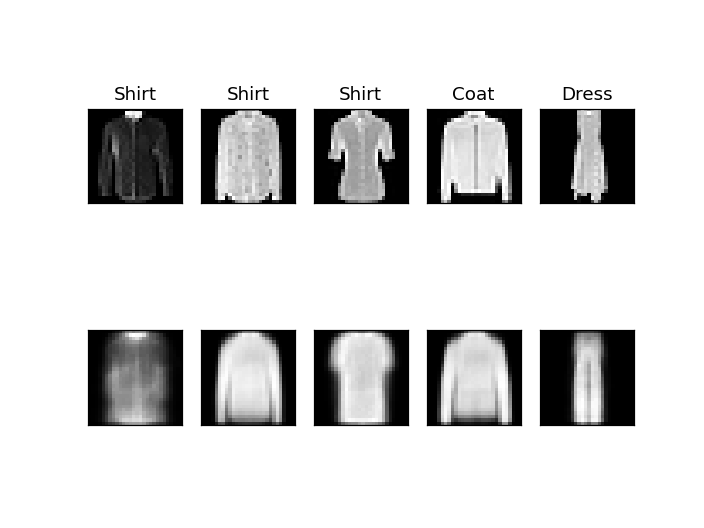

In [22]:
x_hat = vae(x_test).mean().numpy()
vae.encoder.summary()


index = np.random.choice(2000,  5)

fig, ax = plt.subplots(2, 5, num = 'Variational autoenocder reconstruction',
                       subplot_kw={'xticks': [], 'yticks': []})

for i, ind in enumerate(index):
    ax[0,i].imshow(x_test[ind].reshape(28,28), cmap='gray')
    ax[0,i].set_title(labeldict[y_test[ind]])
    ax[1,i].imshow(x_hat[ind].reshape(28,28), cmap='gray')